In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.feature_selection import RFECV 

warnings.filterwarnings('ignore')

In [2]:
# Encode categorical columns by lexicographic order to 0..n-1
def lexi_encode(df: pd.DataFrame, categorical_columns: np.ndarray) -> list:
    df_copy = df.copy()

    print('lexi_encode:')
    max_length = max(map(len, categorical_columns))
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        df_copy[col] = label_encoder.fit_transform(df[col])
        print(col.ljust(max_length), ' -> '.join(label_encoder.classes_))

    X = df_copy.iloc[:, :-1]
    y = df_copy.iloc[:, -1]

    return train_test_split(X, y, test_size=0.2, random_state=71)

# Encode label by mean of CarbonEmission to 0..n-1
# Since we are going to use the result, first split train and test, then encode to prevent using
# the result of test data
def result_encode(df: pd.DataFrame, categorical_columns: np.ndarray) -> list:
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71)

    print('result_encode:')
    max_length = max(map(len, categorical_columns))
    for col in categorical_columns:
        keys = X_train[col].unique()
        values = [y_train[X_train[col] == key].mean() for key in keys]
        indices = np.argsort(values)
        mp = dict(zip(keys[indices], range(len(keys))))
        X_train[col] = X_train[col].map(mp)
        X_test[col] = X_test[col].map(mp)
        print(col.ljust(max_length), ' -> '.join(keys[indices]))

    return X_train, X_test, y_train, y_test

# Encode label by mean of CarbonEmission
def actual_result_encode(df: pd.DataFrame, categorical_columns: np.ndarray) -> list:
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71)

    for col in categorical_columns:
        keys = X_train[col].unique()
        values = np.array([y_train[X_train[col] == key].mean() for key in keys])
        indices = np.argsort(values)
        mp = dict(zip(keys[indices], values[indices]))
        X_train[col] = X_train[col].map(mp)
        X_test[col] = X_test[col].map(mp)

    return X_train, X_test, y_train, y_test

# Tune model using RandomizeSearchCV. Returns top 10 parameters and corresponding scores
def tune_model(clf, params, X, y):
    rs = RandomizedSearchCV(clf, params, n_jobs=-1, random_state=71, n_iter=100)
    rs.fit(X, y)
    res = pd.DataFrame(rs.cv_results_)
    res.sort_values(by='rank_test_score', inplace=True)
    res.reset_index(inplace=True)
    params = pd.DataFrame(res['params'].to_list())
    return pd.concat([params, res['mean_test_score']], axis=1).head(10)

In [3]:
# Read csv
df = pd.read_csv('CarbonEmission.csv')
df

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,obese,male,omnivore,twice a day,coal,private,hybrid,sometimes,230,never,268,medium,5,12,27,9,Yes,[],['Microwave'],2408
9996,normal,female,vegan,twice a day,coal,private,lpg,never,234,frequently,5316,extra large,3,14,8,24,Sometimes,"['Paper', 'Plastic']","['Stove', 'Microwave']",3084
9997,overweight,female,vegetarian,daily,electricity,walk/bicycle,NaN,sometimes,298,very frequently,96,extra large,5,11,5,24,Yes,"['Paper', 'Plastic', 'Metal']","['Microwave', 'Grill', 'Airfryer']",2377
9998,underweight,male,vegan,more frequently,coal,private,petrol,often,179,rarely,8688,medium,5,19,14,5,Sometimes,"['Paper', 'Metal']","['Stove', 'Microwave', 'Grill', 'Airfryer']",4574


In [4]:
# Shorten the columns
df.rename(columns={
    'Body Type': 'Body', 
    'How Often Shower': 'Shower', 
    'Heating Energy Source': 'Heating',
    'Vehicle Type': 'Vehicle',
    'Social Activity': 'Social',
    'Monthly Grocery Bill': 'Grocery',
    'Frequency of Traveling by Air': 'Traveling',
    'Vehicle Monthly Distance Km': 'Vehicle Km',
    'Waste Bag Weekly Count': 'Waste Bag Count',
    'How Long TV PC Daily Hour': 'TV PC Hr',
    'How Many New Clothes Monthly': 'New Clothes',
    'How Long Internet Daily Hour': 'Internet Hr'
}, inplace=True)
df.replace(np.nan, 'None', inplace=True)

In [5]:
# Encode with different methods
categorical_columns = df.select_dtypes(include=['object']).columns
lexi_train, lexi_test, y_train, y_test = lexi_encode(df, categorical_columns)
res_train, res_test, _, _ = result_encode(df, categorical_columns)
ac_res_train, ac_res_test, _, _ = actual_result_encode(df, categorical_columns)

lexi_encode:
Body              normal -> obese -> overweight -> underweight
Sex               female -> male
Diet              omnivore -> pescatarian -> vegan -> vegetarian
Shower            daily -> less frequently -> more frequently -> twice a day
Heating           coal -> electricity -> natural gas -> wood
Transport         private -> public -> walk/bicycle
Vehicle           None -> diesel -> electric -> hybrid -> lpg -> petrol
Social            never -> often -> sometimes
Traveling         frequently -> never -> rarely -> very frequently
Waste Bag Size    extra large -> large -> medium -> small
Energy efficiency No -> Sometimes -> Yes
Recycling         ['Glass', 'Metal'] -> ['Glass'] -> ['Metal'] -> ['Paper', 'Glass', 'Metal'] -> ['Paper', 'Glass'] -> ['Paper', 'Metal'] -> ['Paper', 'Plastic', 'Glass', 'Metal'] -> ['Paper', 'Plastic', 'Glass'] -> ['Paper', 'Plastic', 'Metal'] -> ['Paper', 'Plastic'] -> ['Paper'] -> ['Plastic', 'Glass', 'Metal'] -> ['Plastic', 'Glass'] -> ['Plastic

In [6]:
# Get the correlation of each feature with CarbonEmission
lexi_corr = pd.concat([lexi_train[categorical_columns], y_train], axis=1).corr()['CarbonEmission'].rename('lexi_corr')
res_corr = pd.concat([res_train[categorical_columns], y_train], axis=1).corr()['CarbonEmission'].rename('res_corr')
ac_res_corr = pd.concat([ac_res_train[categorical_columns], y_train], axis=1).corr()['CarbonEmission'].rename('ac_res_corr')
corr = pd.concat([lexi_corr, res_corr, ac_res_corr], axis=1).drop('CarbonEmission')
corr

,lexi_corr,res_corr,ac_res_corr
Body,-0.063291,0.198664,0.199568
Sex,0.169631,0.169631,0.169631
Diet,-0.057877,0.063484,0.068866
Shower,0.013928,0.018132,0.018810
Heating,-0.041327,0.157365,0.161702
Transport,-0.440211,0.440211,0.488722
Vehicle,0.527584,0.594434,0.611781
Social,0.019670,0.058965,0.060210
Traveling,0.248453,0.470709,0.484176
Waste Bag Size,-0.135755,0.135755,0.135957


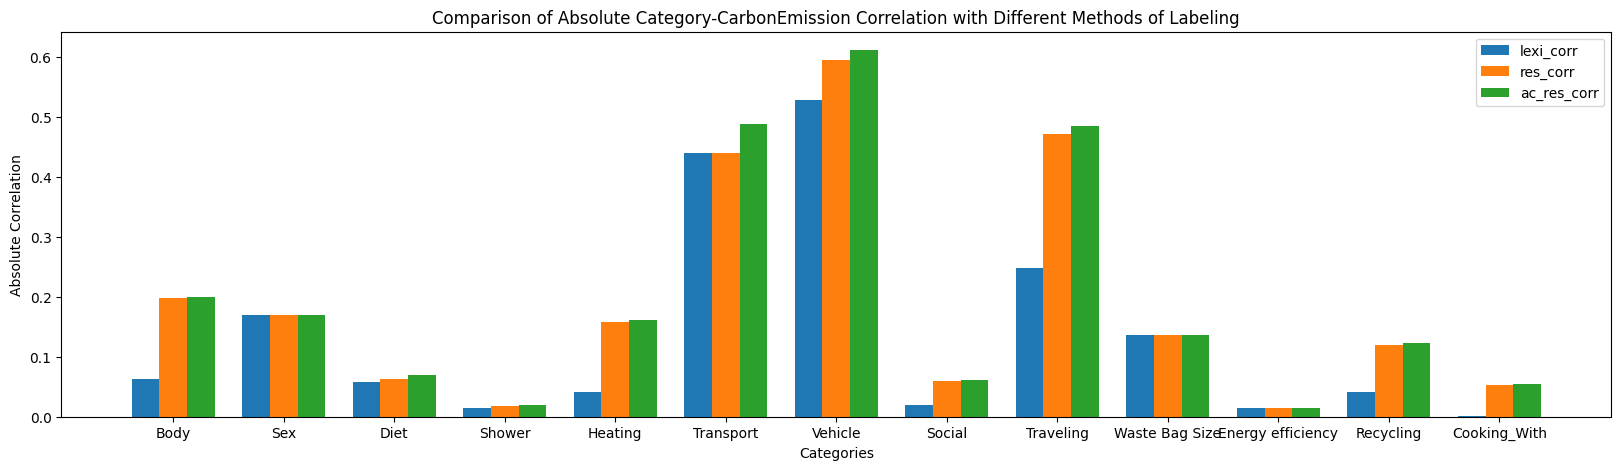

In [7]:
# Visualizing the correlations
num_rows = corr.shape[0]

bar_width = 0.25

# Positions of the bars on the x-axis
indices = range(num_rows)
bar1 = [x - bar_width for x in indices]
bar2 = indices
bar3 = [x + bar_width for x in indices]

plt.figure(figsize=(20, 5))

plt.bar(bar1, list(map(abs, corr['lexi_corr'])), width=bar_width, label='lexi_corr')
plt.bar(bar2, list(map(abs, corr['res_corr'])), width=bar_width, label='res_corr')
plt.bar(bar3, list(map(abs, corr['ac_res_corr'])), width=bar_width, label='ac_res_corr')

plt.xlabel('Categories')
plt.ylabel('Absolute Correlation')
plt.title('Comparison of Absolute Category-CarbonEmission Correlation with Different Methods of Labeling')
plt.xticks(indices, corr.index)
plt.legend()

plt.show()

In [8]:
# Standardize the values
scaler = StandardScaler()
lexi_train = scaler.fit_transform(lexi_train)
lexi_test = scaler.transform(lexi_test)

res_train = scaler.fit_transform(res_train)
res_test = scaler.transform(res_test)

ac_res_train = scaler.fit_transform(ac_res_train)
ac_res_test = scaler.transform(ac_res_test)

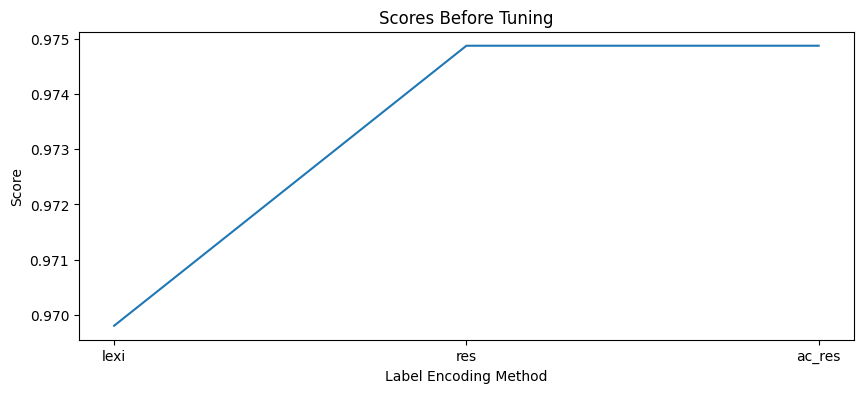

In [9]:
# Scores without tuning
scores = []
for X_train, X_test in ((lexi_train, lexi_test), (res_train, res_test), (ac_res_train, ac_res_test)):
    clf = XGBRegressor()
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 4))

plt.plot(['lexi', 'res', 'ac_res'], scores)

plt.title('Scores Before Tuning')
plt.xlabel('Label Encoding Method')
plt.ylabel('Score')

plt.show()

In [10]:
# Initial tuning lexi
learning_rates = list(i / 10 for i in range(1, 10))
n_estimators = list(range(1000, 4001, 500))
max_depths = list(range(2, 5))
min_child_weights = list(range(2, 5))
params = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths, 'min_child_weight': min_child_weights}
tune_model(XGBRegressor(), params, lexi_train, y_train)

,n_estimators,min_child_weight,max_depth,learning_rate,mean_test_score
0,4000,4,2,0.4,0.989239
1,3500,4,2,0.4,0.989232
2,4000,3,2,0.3,0.989218
3,3500,2,2,0.5,0.989145
4,2500,2,2,0.5,0.989125
5,3500,2,2,0.3,0.989115
6,3000,4,2,0.5,0.989114
7,3000,3,2,0.3,0.988977
8,4000,4,2,0.6,0.988905
9,3500,3,2,0.6,0.988878


In [11]:
# Further tuning lexi
learning_rates = list(i / 10 for i in range(3, 6))
n_estimators = list(range(2500, 4501, 100))
max_depths = [2]
min_child_weights = list(range(2, 6))
params = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths, 'min_child_weight': min_child_weights}
tune_model(XGBRegressor(), params, lexi_train, y_train)

,n_estimators,min_child_weight,max_depth,learning_rate,mean_test_score
0,4200,4,2,0.3,0.989340
1,4400,4,2,0.3,0.989339
2,4500,5,2,0.3,0.989314
3,4000,4,2,0.3,0.989303
4,4500,3,2,0.3,0.989290
5,3900,4,2,0.3,0.989290
6,4000,5,2,0.3,0.989270
7,4500,2,2,0.3,0.989269
8,3900,5,2,0.3,0.989261
9,4200,2,2,0.3,0.989255


In [12]:
# Result of lexi
lexi_best_params = {'n_jobs': -1, 'n_estimators': 4200, 'min_child_weight': 4, 'max_depth': 2, 'learning_rate': 0.3}
clf = XGBRegressor(**lexi_best_params)
clf.fit(lexi_train, y_train)
clf.score(lexi_test, y_test)

0.9904824802961372

In [13]:
# Initial tuning res
learning_rates = list(i / 10 for i in range(1, 10))
n_estimators = list(range(1000, 4001, 500))
max_depths = list(range(2, 5))
min_child_weights = list(range(2, 5))
params = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths, 'min_child_weight': min_child_weights}
tune_model(XGBRegressor(), params, res_train, y_train)

,n_estimators,min_child_weight,max_depth,learning_rate,mean_test_score
0,3500,4,2,0.4,0.990244
1,4000,4,2,0.4,0.990212
2,3000,3,3,0.1,0.990030
3,2500,2,3,0.1,0.990008
4,3500,2,3,0.1,0.989985
5,4000,3,2,0.3,0.989896
6,3000,3,2,0.3,0.989882
7,3000,4,2,0.5,0.989879
8,2500,2,2,0.5,0.989869
9,3500,2,2,0.3,0.989862


In [14]:
# Further tuning res
learning_rates = list(i / 10 for i in range(1, 6))
n_estimators = list(range(2500, 4501, 100))
max_depths = [2, 3]
min_child_weights = list(range(2, 6))
params = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths, 'min_child_weight': min_child_weights}
tune_model(XGBRegressor(), params, res_train, y_train)

,n_estimators,min_child_weight,max_depth,learning_rate,mean_test_score
0,2700,5,2,0.4,0.990281
1,3200,4,2,0.4,0.990277
2,2600,5,2,0.4,0.990276
3,2800,3,2,0.4,0.990273
4,3100,5,2,0.4,0.990254
5,3900,2,2,0.4,0.990253
6,3400,3,2,0.4,0.990249
7,3400,5,2,0.4,0.990226
8,3600,5,2,0.4,0.990225
9,3500,5,2,0.4,0.990221


In [15]:
# Result of res
res_best_params = {'n_jobs': -1, 'n_estimators': 2700, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.4}
clf = XGBRegressor(**res_best_params)
clf.fit(res_train, y_train)
clf.score(res_test, y_test)

0.9909595980253393

In [16]:
# Initial tuning ac_res
learning_rates = list(i / 10 for i in range(1, 10))
n_estimators = list(range(1000, 4001, 500))
max_depths = list(range(2, 5))
min_child_weights = list(range(2, 5))
params = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths, 'min_child_weight': min_child_weights}
tune_model(XGBRegressor(), params, ac_res_train, y_train)

,n_estimators,min_child_weight,max_depth,learning_rate,mean_test_score
0,3500,4,2,0.4,0.990244
1,4000,4,2,0.4,0.990212
2,3000,3,3,0.1,0.990030
3,2500,2,3,0.1,0.990008
4,3500,2,3,0.1,0.989985
5,4000,3,2,0.3,0.989896
6,3000,3,2,0.3,0.989882
7,3000,4,2,0.5,0.989879
8,2500,2,2,0.5,0.989869
9,3500,2,2,0.3,0.989862


In [17]:
# Further tuning ac_res
learning_rates = list(i / 10 for i in range(1, 6))
n_estimators = list(range(2500, 4001, 100))
max_depths = [2, 3]
min_child_weights = list(range(2, 6))
params = {'learning_rate': learning_rates, 'n_estimators': n_estimators, 'max_depth': max_depths, 'min_child_weight': min_child_weights}
tune_model(XGBRegressor(), params, ac_res_train, y_train)

,n_estimators,min_child_weight,max_depth,learning_rate,mean_test_score
0,3000,2,2,0.4,0.990330
1,2700,5,2,0.4,0.990281
2,3200,3,2,0.4,0.990267
3,2900,3,2,0.4,0.990265
4,3400,3,2,0.4,0.990249
5,3400,4,2,0.4,0.990242
6,3900,5,2,0.4,0.990199
7,2700,4,3,0.1,0.990123
8,3300,4,3,0.1,0.990103
9,3400,4,3,0.1,0.990096


In [18]:
# Result of ac_res
ac_res_best_params = {'n_jobs': -1, 'n_estimators': 3000, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.4}
clf = XGBRegressor(**ac_res_best_params)
clf.fit(ac_res_train, y_train)
clf.score(ac_res_test, y_test)

0.9910046748027488

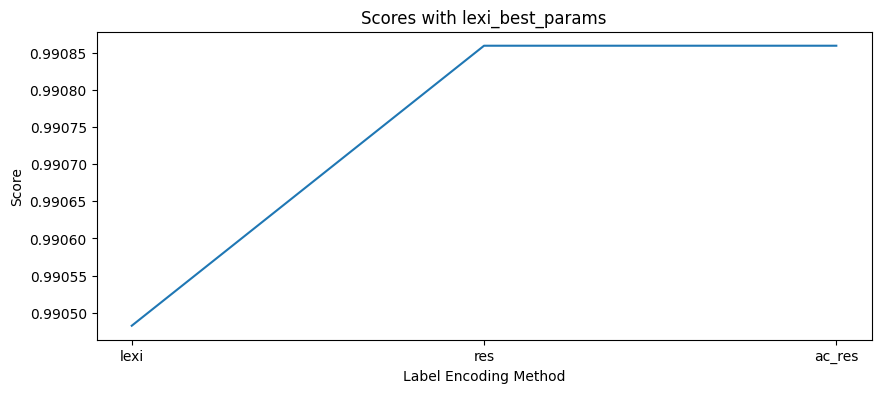

In [19]:
# Scores with lexi_best_params
scores = []
for X_train, X_test in ((lexi_train, lexi_test), (res_train, res_test), (ac_res_train, ac_res_test)):
    clf = XGBRegressor(**lexi_best_params)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 4))

plt.plot(['lexi', 'res', 'ac_res'], scores)

plt.title('Scores with lexi_best_params')
plt.xlabel('Label Encoding Method')
plt.ylabel('Score')

plt.show()

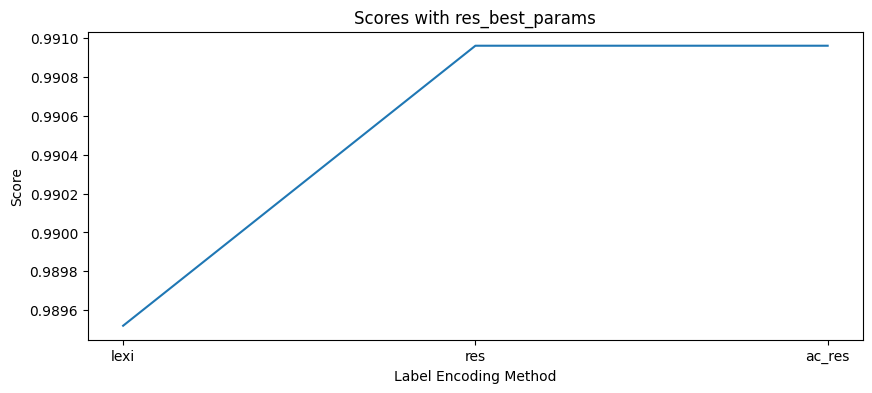

In [20]:
# Scores with res_best_params
scores = []
for X_train, X_test in ((lexi_train, lexi_test), (res_train, res_test), (ac_res_train, ac_res_test)):
    clf = XGBRegressor(**res_best_params)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 4))

plt.plot(['lexi', 'res', 'ac_res'], scores)

plt.title('Scores with res_best_params')
plt.xlabel('Label Encoding Method')
plt.ylabel('Score')

plt.show()

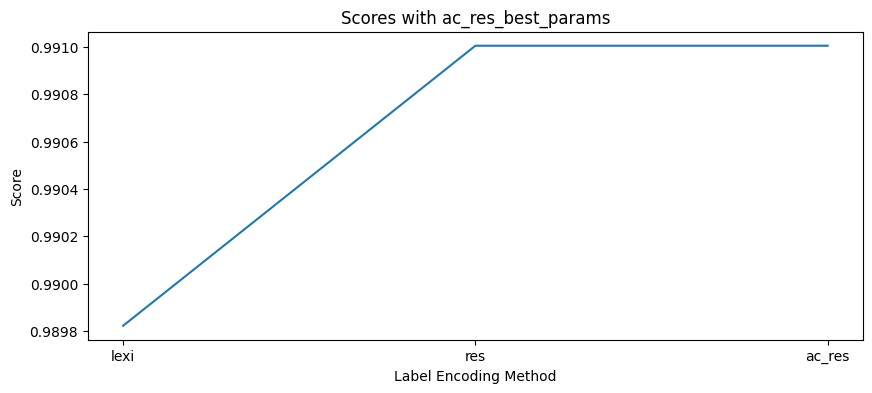

In [21]:
# Scores with ac_res_best_params
scores = []
for X_train, X_test in ((lexi_train, lexi_test), (res_train, res_test), (ac_res_train, ac_res_test)):
    clf = XGBRegressor(**ac_res_best_params)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 4))

plt.plot(['lexi', 'res', 'ac_res'], scores)

plt.title('Scores with ac_res_best_params')
plt.xlabel('Label Encoding Method')
plt.ylabel('Score')

plt.show()

In [22]:
lexi_feature_importances = XGBRegressor(**lexi_best_params).fit(lexi_train, y_train).feature_importances_
res_feature_importances = XGBRegressor(**res_best_params).fit(res_train, y_train).feature_importances_
ac_res_feature_importances = XGBRegressor(**ac_res_best_params).fit(ac_res_train, y_train).feature_importances_

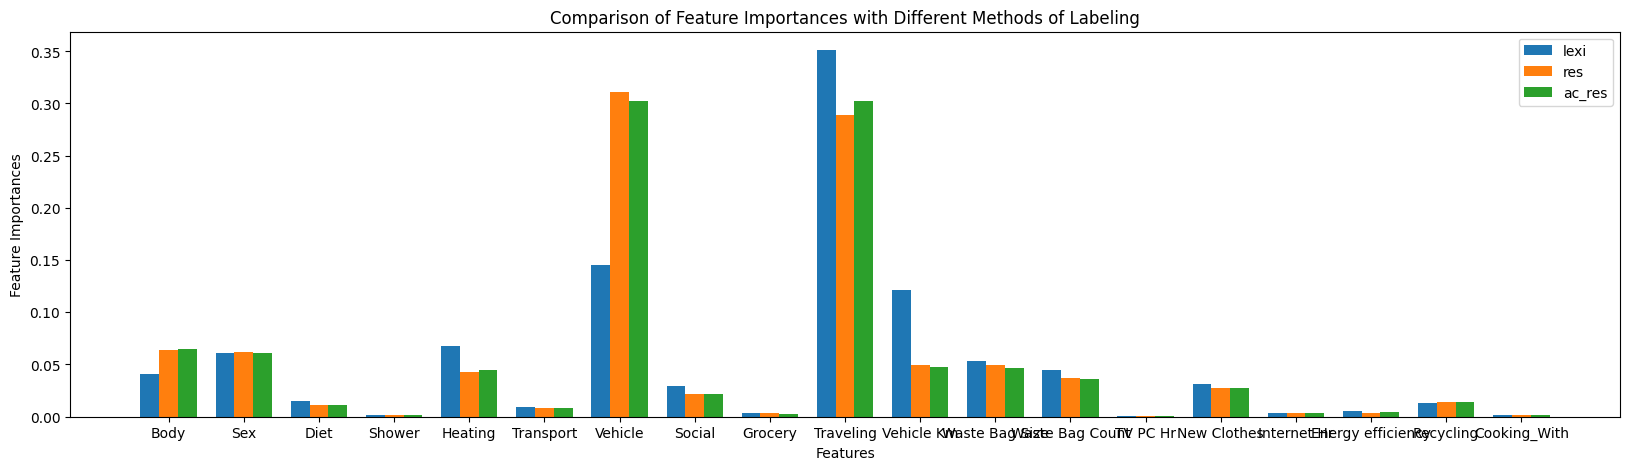

In [23]:
# Visualizing the feature importances best models of different encoding methods
num_features = lexi_feature_importances.shape[0]

bar_width = 0.25

indices = range(num_features)
bar1 = [x - bar_width for x in indices]
bar2 = indices
bar3 = [x + bar_width for x in indices]

plt.figure(figsize=(20, 5))

plt.bar(bar1, lexi_feature_importances, width=bar_width, label='lexi')
plt.bar(bar2, res_feature_importances, width=bar_width, label='res')
plt.bar(bar3, ac_res_feature_importances, width=bar_width, label='ac_res')

plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Comparison of Feature Importances with Different Methods of Labeling')
plt.xticks(indices, df.columns[:-1])
plt.legend()

plt.show()

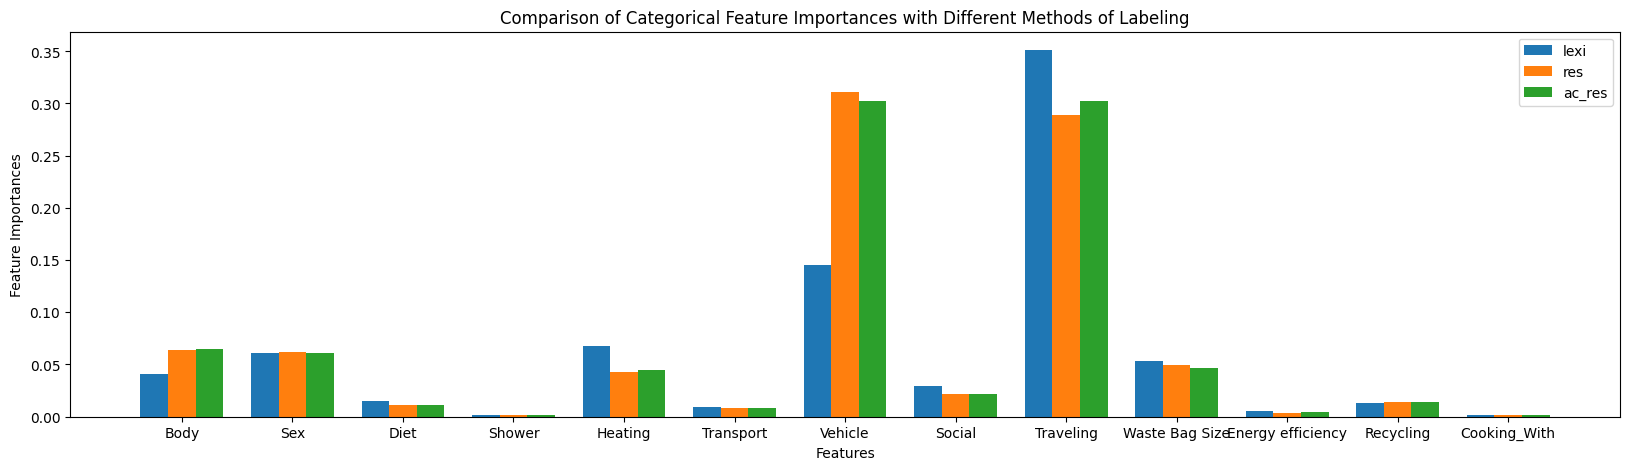

In [24]:
# Visualizing the categorical feature importances best models of different encoding methods
categorical_indices = [df.columns.get_loc(col) for col in categorical_columns]

num_features = len(categorical_indices)

bar_width = 0.25

indices = range(num_features)
bar1 = [x - bar_width for x in indices]
bar2 = indices
bar3 = [x + bar_width for x in indices]

plt.figure(figsize=(20, 5))

plt.bar(bar1, lexi_feature_importances[categorical_indices], width=bar_width, label='lexi')
plt.bar(bar2, res_feature_importances[categorical_indices], width=bar_width, label='res')
plt.bar(bar3, ac_res_feature_importances[categorical_indices], width=bar_width, label='ac_res')

plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Comparison of Categorical Feature Importances with Different Methods of Labeling')
plt.xticks(indices, categorical_columns)
plt.legend()

plt.show()

XGBoost grows the tree by spliting and adjusting the spliting parameters. If the categorical labels are not encoded by the correct order, it is harder for XGBoost to find more general parameters. Hence we can find that the result_encoding and actual_result_encoding perform better than lexicographic encoding in all the above cases, inclulding using the best parameters of lexi.